<a href="https://colab.research.google.com/github/HermitCrab07/Impact_of_HbA1c_on_Readmission_Rates/blob/main/_5_DoWhy_Diabetes130US_Hospitals_1999_2008_3_CAUSAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

Moving on with our causal analysis to figure out if the measurement of HbA1c ('Treatment') reduces the risk of readmission?

Without question - there can be many reasons why a person is readmitted to the hospital. These range from continuation of the same issue that is currently under treatment to injuries or illness that occur after discharge that have nothing to do with the current hospitalization.

However many other issues there may be, for this example, we are going to examine the readmission rates using the diabetes dataset and variables available to us.

---


In [3]:
# Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore
# Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records
# BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.
# Dataset was downloaded from UCI Machine Learning Repository.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Analysis_Diabetes_Dataset_CausalInference/reanalysis_diabetes_dataset.csv')
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,Treatment,Insured,Readmission
count,7.151800e+04,7.151800e+04,71518.000000,71518.000000,71518.000000,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,1.568156e+08,5.505160e+07,2.100254,3.593235,5.657457,4.28913,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,7.245700,0.215163,0.565941,0.398962
std,1.003769e+08,3.947573e+07,1.508301,5.269771,4.162580,2.94921,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,1.994674,0.410938,0.495636,0.489688
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,8.145807e+07,2.337577e+07,1.000000,1.000000,1.000000,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,1.440574e+08,4.816680e+07,1.000000,1.000000,7.000000,3.00000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000
75%,2.155513e+08,8.752222e+07,3.000000,3.000000,7.000000,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000,0.000000,1.000000,1.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.00000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000,1.000000,1.000000,1.000000


In [ ]:
!pip install dowhy==0.8
import dowhy
from dowhy import CausalModel

import pandas as pd
import numpy as np



---

Using DoWhy to estimate the Causal Effect: First define the Causal Graph using the variables that are in the dataset -

*   Age
*   Race
*   Gender
*   Treatment
*   Insured (Yes/N0)
*   Number of Medications
*   Number of Procedures
*   Number of Emergency Procedures

---



In [ ]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install --force-reinstall pygraphviz

In [13]:
import pygraphviz

Will use pygraphviz to explicitly define the relationships between the variables:

Building this causal model using a graph helps show and clarify the causal relationships between variables, making the assumptions transparent and easier to understand for me as well as any user who might want to examine the assumptions. This transparency helps in identifying potential biases/confounders that might influence the analysis.


Domain Expertise Incorporation:

Explicitly defining the causal model allows me to show my domain expertise (which is zero - as I'm neither an insurance nor a medical expert). But living in the US has given me some level of prior knowledge about the relationships between these variables. I'm hoping this ensures the causal assumptions are based on more than mere guesses.


Refutation and Validation:

A well-defined causal model gives us the ability to do robust refutation and validation checks on the causal estimates. By explicitly stating the assumptions, we assess the sensitivity of the results to violations of these assumptions.


Communication and Collaboration:

Visualizing the causal model with a graph helps communication/collaboration with those who have far more background than I do. It provides a clear way to share my understanding of the causal relationships underlying the analysis.

Targeted Causal Questions:

Building a causal model allows us to frame both specific and targeted questions. By focusing on the relationships of interest, one can design experiments or analyses that are better suited to answering our specific research questions.

In summary, while DoWhy doesn't demand the model visualization, explicitly specifying the causal model using PyGraphviz helps me get a clear idea of what I am assuming and makes it easier for a real insurance or medical expert to question my assumptions:



In [49]:
causal_graph = """digraph {
Treatment[label="Measurement of Hb1Ac"];
Insured[label="Insured Or Not"];
"Number of Medications"[label="Number of Medications Prescribed to Patient"];
"Number of Procedures"[label="Number of Procedures Performed"];
"Number of Emergency Procedures"[label="Number of Emergency Procedures Performed"];
Readmission[label="Readmission"];
Treatment -> Readmission;
Insured -> Readmission;
Insured -> Treatment;
"Number of Medications" -> Readmission;
"Number of Procedures" -> Readmission;
"Number of Emergency Procedures" -> Readmission
}"""

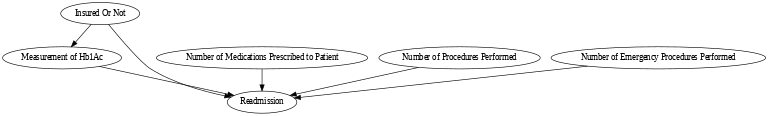

In [69]:
model = dowhy.CausalModel(
    data=df,
    graph=causal_graph,
    treatment=["Treatment"],
    outcome="Readmission",
)

model.view_model()

from IPython.display import Image, display
# Display the image (without forcing dimensions)
display(Image(filename="causal_model.png", width=800, height=200))

In [70]:
# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[Readmission|Insured])
d[Treatment]                        
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Readmission then P(Readmission|Treatment,Insured,U) = P(Readmission|Treatment,Insured)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [71]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print(estimate)

propensity_score_stratification


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[Readmission|Insured])
d[Treatment]                        
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Readmission then P(Readmission|Treatment,Insured,U) = P(Readmission|Treatment,Insured)

## Realized estimand
b: Readmission~Treatment+Insured
Target units: ate

## Estimate
Mean value: 0.09593524401652559



In [72]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting", target_units = "ate")
print(estimate)

propensity_score_weighting


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[Readmission|Insured])
d[Treatment]                        
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Readmission then P(Readmission|Treatment,Insured,U) = P(Readmission|Treatment,Insured)

## Realized estimand
b: Readmission~Treatment+Insured
Target units: ate

## Estimate
Mean value: 0.09593524331334663



In [73]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting", target_units = "att")
print(estimate)

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[Readmission|Insured])
d[Treatment]                        
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Readmission then P(Readmission|Treatment,Insured,U) = P(Readmission|Treatment,Insured)

## Realized estimand
b: Readmission~Treatment+Insured
Target units: att

## Estimate
Mean value: 0.09677112445134556



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [74]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_weighting", target_units = "atc")
print(estimate)

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[Readmission|Insured])
d[Treatment]                        
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Readmission then P(Readmission|Treatment,Insured,U) = P(Readmission|Treatment,Insured)

## Realized estimand
b: Readmission~Treatment+Insured
Target units: atc

## Estimate
Mean value: 0.0957061165375081



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
refute1_results = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(refute1_results)

In [ ]:
refute2_results = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print(refute2_results)